In [1]:
# %matplotlib widget 
# ! pip install ipympl 
# ! jupyter labextension install jupyter-matplotlib

In [2]:
import xrayutilities as xu # if not installed run "! pip install xrayutilities"
import numpy as np
import json, os
from collections import OrderedDict
from matplotlib import pyplot as plt
from scipy.optimize import minimize, differential_evolution
from scipy.io import loadmat
from utils_funcs import objFunc, build_crystal, simFunc, cluster_lscans

### Build layers

In [3]:
cif = xu.materials.cif.CIFFile("../cif_files/MoS2_254956.cif")
mos2 = xu.materials.Crystal('MoS2', cif.SGLattice())
cif = xu.materials.cif.CIFFile("../cif_files/WSe2_84182.cif")
wse2 = xu.materials.Crystal('WSe2', cif.SGLattice())

XU.material: element Mo used instead of Mo4+
XU.material: element S used instead of S2-
XU.material: element W used instead of W4+
XU.material: element Se used instead of Se2-


In [4]:
sio2_crystal = xu.materials.SiO2
# sio2_amorphous = xu.materials.Amorphous('SiO2', density=sio2_crystal.density) # this builds an amorphous SiO2 substrate. For qmax=1/Å, it shouldn't make much difference between sio2_amorphous and sio2_crystal
substrate = xu.simpack.Layer(sio2_crystal,np.inf, roughness=1.00) 
wse2_layer = xu.simpack.Layer(wse2, 3.375, roughness=0.00) # double-check thickness!!! 
mos2_layer = xu.simpack.Layer(mos2, 3.067, roughness=0.00) # double-check thickness!!! 
vacuum = xu.materials.Amorphous('vacuum', 1e-10, atoms=[('H', 0.)]) 

In [5]:
wse2_slab = xu.materials.Amorphous('WSe2', wse2.density)
mos2_slab = xu.materials.Amorphous('MoS2', mos2.density)
wse2_layer = xu.simpack.Layer(wse2_slab, wse2.c, roughness=0.00)
print("WSe2 layer lattice parameter, c = %.3f \n" % wse2.c)
mos2_layer = xu.simpack.Layer(mos2_slab, mos2.c, roughness=0.00)

WSe2 layer lattice parameter, c = 12.980 



In [6]:
spacing = 8
layer_dict = OrderedDict({"layer_1": {"wse2": 1}, 
                          "layer_2": {"vacuum": spacing}, 
                          "layer_3": {"mos2": 0},
                          "layer_4": {"vacuum": spacing}, 
                          "layer_5": {"mos2": 0},
                          "layer_6": {"vacuum": spacing},
                          "layer_7": {"mos2": 0}})

### Simulate

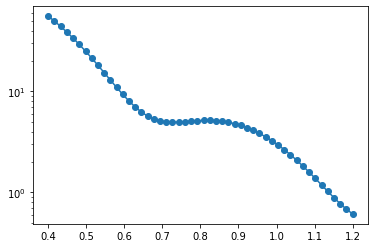

In [10]:
film = build_crystal(layer_seq=layer_dict, mos2_layer=mos2_layer, wse2_layer=wse2_layer, 
                     substrate=substrate, vacuum=vacuum, stack_name="1_1_1", substrate_spacing=10.,
                    roughness=0.1, wse2_thickness = wse2.c/4)
en = 10000
# resolution = np.rad2deg(2e-3)
m = xu.simpack.SpecularReflectivityModel(film, sample_width=10, beam_width=0.1, energy=en, I0=1e6)
qz = np.linspace(0.4, 1.2, 50)
alpha = np.rad2deg(np.arcsin(xu.en2lam(en) * qz / (4* np.pi)))
Ixrr = m.simulate(alpha)
plt.figure(1)
plt.semilogy(qz, Ixrr, marker='o')
plt.show()

#### e-density profile

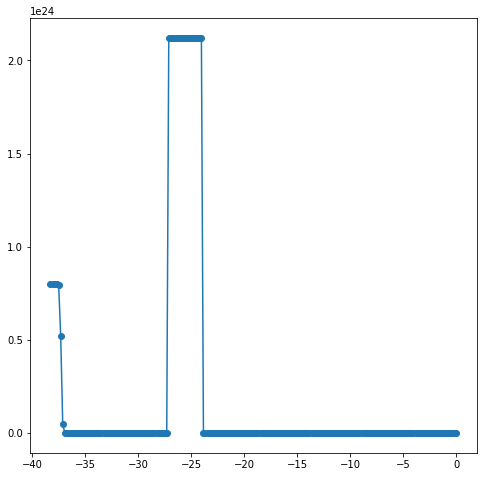

In [11]:
z, e_dens = m.densityprofile(200, plot=False)
plt.figure(figsize=(8,8))
# plt.plot(z[97:155], e_dens[97:155], marker='o')
# slic = slice(167,175)
plt.plot(z, e_dens, marker='o')
# plt.plot(z[slic], e_dens[slic], marker='o')
plt.show()

#### Load Data

In [12]:
data_dict = loadmat("../data/cubeN.mat")
data_arr = data_dict['cubeN']
data_arr = data_arr.transpose(2,0,1)
qz_arr = loadmat('../data/Qz.mat')['Qz']

Text(0.5, 1.0, 'Lscan averaged over image')

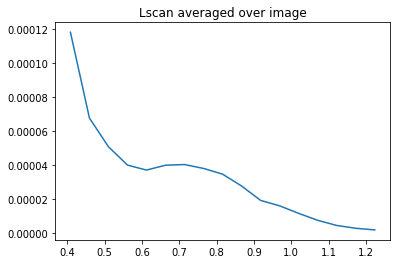

In [13]:
plt.figure()
plt.plot(qz_arr, data_arr.mean(axis=(1,2)))
plt.title('Lscan averaged over image')

#### Use k-means clustering (unsupervised machine learning) to assign each L-scan in the data to a cluster

In [14]:
num_clusters = 8
labels_imp, lscan_centers, lscan_labels = cluster_lscans(data_arr, num_clusters=num_clusters)

Number of L-scans per cluster: 

[129492, 79271, 133019, 460227, 29894, 77873, 315875, 78925]


#### plot cluster labels for each l-scan spatial location

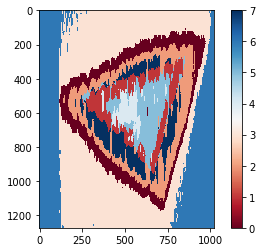

In [15]:
plt.figure()
plt.imshow(labels_imp.astype(np.int8), cmap='RdBu')
plt.colorbar()

#### plot the average l-scan for each cluster

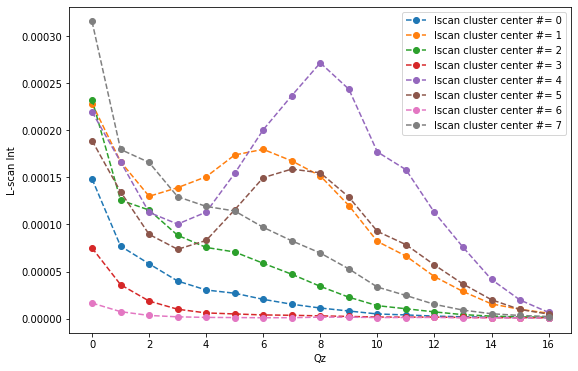

In [16]:
#Show clusters
fig, ax = plt.subplots(figsize=(9,6))
for cen, lscan in enumerate(lscan_centers):
    ax.plot(lscan, marker='o', linestyle='dashed', label='lscan cluster center #= %d' % cen)
ax.set_xlabel('Qz')
ax.set_ylabel('L-scan Int')
ax.legend()

#### Let's ignore clusters #6, #3, #0 since they are either background reflectivilty or have no data(by setting their cluster label to -1)

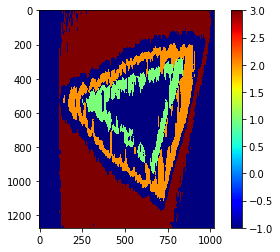

In [17]:
cluster_ignore = [0, 4,5, 6,7]
for clus in cluster_ignore:
    labels_imp[labels_imp == clus] = -1
plt.figure()
plt.imshow(labels_imp.astype(np.int8), cmap='jet')
plt.colorbar()

#### Let's fit the remaining clusters...

In [18]:
data = np.copy(data_arr)
data = data.transpose(1,2,0)
orig_shape = data.shape
data = data.reshape(-1, data.shape[-1])
label_masks = [ lscan_labels == cen for cen in range(num_clusters) if cen not in cluster_ignore ]
lscan_centers = [ lscan_cen  for (num, lscan_cen) in enumerate(lscan_centers) if num not in cluster_ignore]
lscan_masked = [data[mask] for mask in label_masks]

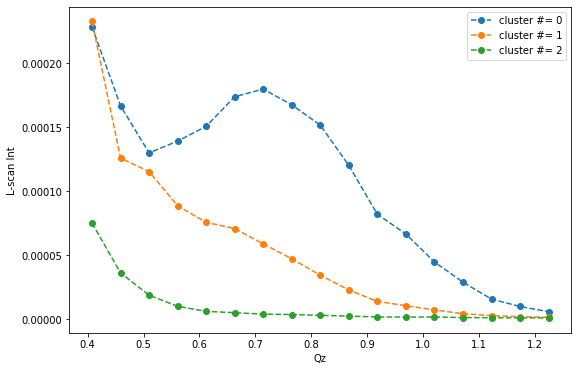

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
for cen, lscan in enumerate(lscan_centers):
    ax.plot(qz_arr, lscan, marker='o', linestyle='dashed', label='cluster #= %d' % cen)
ax.set_xlabel('Qz')
ax.set_ylabel('L-scan Int')
ax.legend()

### Fitting Algorithm:  
__1__ Run Genetic Algorithms on all of the lscans that belong to a cluster with the same bounds/params to generate a single fit (call it cluster fit).  
__2__ Use the GA fit as a starting guess for all of the lscans that belong to cluster, and refine the cluster fit using a less expensive gradient-based method.  
__3__ For each lscan in the cluster using the single fit as starting guess and refine it for each invidual lscan in the image using a gradient-based method.

In [20]:
# set fitting parameter bounds (lower, upper) limits
dic = {'substrate_wse2_spacing':(1, 10), # spacings in Å
       'wse2_mos2_spacing':(2, 4), # only used if mos2 layer_1 occupation is not 0
       'mos2_mos2_spacing':(2, 4), # only used if mos2 layer_2 occupation is not 0
       'mos2_layer_1_occ':(0.1,1.5), # mos2 layer_1 occupation: this is converted to binary (0,1) in the fitting function
       'mos2_layer_2_occ':(0.1,1.5), # this is only considered if 'mos2_layer_1_occ' is 1.
       'roughness':(0.1, 1.0), # substrate roughness Å
       'scaling':(0.1, 100), # scaling factor of the absolute reflectivity
       'q_offset':(-0.005, 0.005), # constant q_offset of the entire q_z data points in 1/Å
       'wse2_t': (2.5, 5.0), # thickness of wse2 layers Å (this shouldn't be fitted necessarily... but it's good consistency check), ideal = 3.3748
       'mos2_t': (2.5, 5.0)} # thickness of mos2 layers Å (this shouldn't be fitted necessarily... but it's good consistency check), ideal = 3.0676

bounds = (dic['substrate_wse2_spacing'], dic['wse2_mos2_spacing'], dic['mos2_mos2_spacing'], 
          dic['roughness'], dic['mos2_layer_1_occ'], dic['mos2_layer_2_occ'], dic['scaling'], 
          dic['q_offset'], dic['wse2_t'], dic['mos2_t'])

def print_save_results(results, cluster_num, path=os.path.join(os.getcwd(), 'fit_results'), fit_method='GA', save=True):
    # load and print results
    spacing_1, spacing_2, spacing_3, roughness, layer_occ_1, layer_occ_2, scaling, q_offset, wse2_t, mos2_t = results.x

    print('\n\nsubstrate-WSe2 spacing= {spacing_1:2.3f} Å, \nWSe2-MoS2 spacing= {spacing_2:2.3f}Å'\
          '\nMoS2_1-MoS2_2 spacing= {spacing_3:2.3f}Å,'\
          '\nMoS2_1 occupation={occ_1:d}, \nMoS2_2 occupation={occ_2:d}, \nroughness={roughness:2.3f}Å, \nq_offset={q_offset:2.2e} 1/Å,'\
          '\nWSe2 thickness={wse2_t:2.3f}Å, \nMoS2 thickness={mos2_t:2.3f}Å'.format(spacing_1=spacing_1, spacing_2=spacing_2, spacing_3=spacing_3,
                                                                      occ_1=int(layer_occ_1), occ_2=int(layer_occ_2), 
                                                                      roughness=roughness, wse2_t=wse2_t, mos2_t=mos2_t, q_offset=q_offset))
    if save:
        fname = 'fit_%s_cluster_num_%d.npy' %(fit_method, cluster_num)
        fpath = os.path.join(path,fname)
        np.save(fpath, results.x)
    return


#### 1. Run GA

In [21]:
result_list = []
crystal_layers = [substrate, mos2_layer, wse2_layer, vacuum]
fraction = 0.001 # fraction of l-scans to fit- only used when not fitting the per-cluster center (=average)
# for (clust_cent, xrr_data) in enumerate(lscan_masked): # this uses all the l-scans per cluster
for (clust_cent, xrr_data) in enumerate(lscan_centers): # this uses only the per cluster lscan average
    print("\n####### Starting cluster %d ############ \n" % clust_cent)
    # get fraction of lscans
    if len(xrr_data.shape) > 1:
        fraction = min(1, fraction)
        fract = int(xrr_data.shape[0] * fraction) - 1
        xrr_data = xrr_data[:fract]
        print('Fitting %d L-scans simultaneously' % xrr_data.shape[0])
        
    
    # Call differential evolution
    results = differential_evolution(objFunc, bounds, args=(xrr_data,qz_arr, crystal_layers), strategy='best1bin',
                                     disp=False, popsize=30, maxiter=int(500), recombination=0.5,  # reduce popsize and maxiter for faster (but less accurate results)
                                     mutation=(0.5, 1.0), init='latinhypercube', polish=True, tol=0.01)

    print_save_results(results, clust_cent)
    result_list.append(results)
    print("\n####### Finished with cluster %d ############ \n" % clust_cent)


####### Starting cluster 0 ############ 



substrate-WSe2 spacing= 4.669 Å, 
WSe2-MoS2 spacing= 3.319Å
MoS2_1-MoS2_2 spacing= 2.773Å,
MoS2_1 occupation=1, 
MoS2_2 occupation=0, 
roughness=0.998Å, 
q_offset=4.93e-03 1/Å,
WSe2 thickness=4.262Å, 
MoS2 thickness=2.500Å

####### Finished with cluster 0 ############ 


####### Starting cluster 1 ############ 



substrate-WSe2 spacing= 1.966 Å, 
WSe2-MoS2 spacing= 2.660Å
MoS2_1-MoS2_2 spacing= 3.398Å,
MoS2_1 occupation=0, 
MoS2_2 occupation=1, 
roughness=0.154Å, 
q_offset=-3.01e-03 1/Å,
WSe2 thickness=4.701Å, 
MoS2 thickness=3.838Å

####### Finished with cluster 1 ############ 


####### Starting cluster 2 ############ 



substrate-WSe2 spacing= 9.898 Å, 
WSe2-MoS2 spacing= 2.580Å
MoS2_1-MoS2_2 spacing= 2.965Å,
MoS2_1 occupation=0, 
MoS2_2 occupation=0, 
roughness=0.112Å, 
q_offset=-4.35e-03 1/Å,
WSe2 thickness=5.000Å, 
MoS2 thickness=4.429Å

####### Finished with cluster 2 ############ 



#### Plot Fit Results

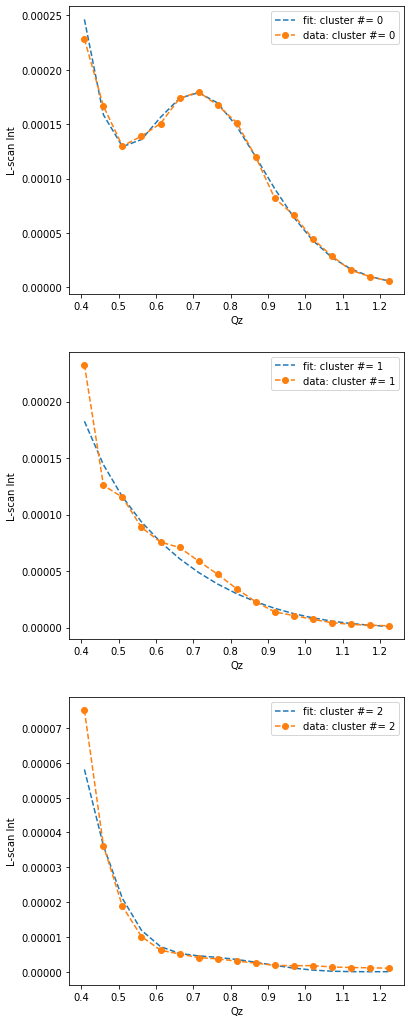

In [23]:
fig, axes = plt.subplots(len(lscan_centers),1, figsize=(6,18))
for ax, res, (cen, lscan) in zip(axes.flatten(), result_list, enumerate(lscan_centers)):
    xrr_fit, edens = simFunc(res.x, lscan , qz_arr, crystal_layers, fit_return=True)
#     print(res.x)
    ax.plot(qz_arr, xrr_fit, linestyle='dashed', label='fit: cluster #= %d' % cen)
    ax.plot(qz_arr, lscan, marker='o', linestyle='dashed', label='data: cluster #= %d' % cen)
    ax.set_xlabel('Qz')
    ax.set_ylabel('L-scan Int')
    ax.legend()
fig.savefig('fit_plots/fit_results_GA.png', dpi=200)

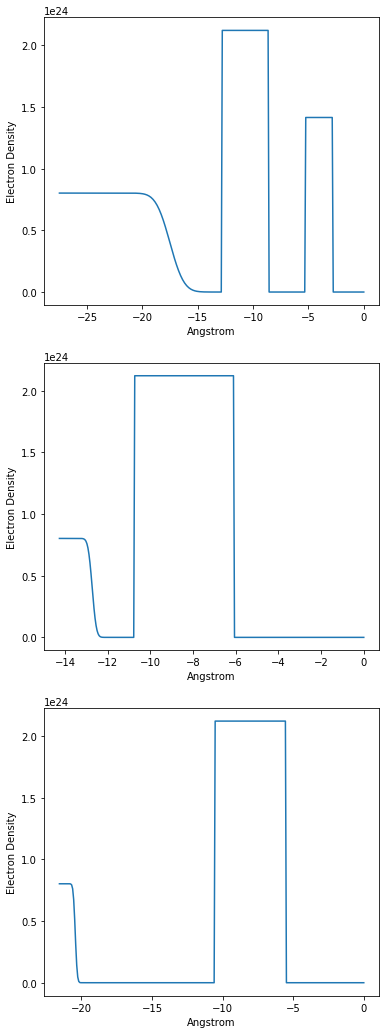

In [24]:
fig, axes = plt.subplots(len(lscan_centers),1, figsize=(6,18))
for ax, res, (cen, lscan) in zip(axes.flatten(), result_list, enumerate(lscan_centers)):
    xrr_fit, (z, edens) = simFunc(res.x, lscan , qz_arr, crystal_layers, fit_return=True)
#     print(res.x)
    ax.plot(z,edens)
    ax.set_xlabel('Angstrom')
    ax.set_ylabel('Electron Density')
#     ax.legend()
fig.savefig('fit_plots/fit_edens.png', dpi=200)

In [25]:
# for (clust, results) in enumerate(result_list):
#     print_save_results(results, clust, save=False)

#### 2. Refine with gradient-based optimization

In [26]:
grad_result_list = []
fraction = 0.005 # fraction ofprint_save_resultso fit- only used when not fitting the per-cluster average
for x_0, (clust_cent, xrr_data) in zip(result_list, enumerate(lscan_centers)):
# for x_0, (clust_cent, xrr_data) in zip(result_list, enumerate(lscan_masked)):
    print("\n####### Starting cluster %d ############ \n" % clust_cent)
    # get fraction of lscans
    if len(xrr_data.shape) > 1:
        fraction = min(1, fraction)
        fract = int(xrr_data.shape[0] * fraction) - 1
        xrr_data = xrr_data[:fract]
        print('Fitting %d L-scans simultaneously' % xrr_data.shape[0])
    
    # Minimize
    results = minimize(objFunc, x_0.x, bounds=bounds, args=(xrr_data,qz_arr, crystal_layers), 
                       options={'maxiter':1e4, 'disp':True}, tol=1e-5)
    print(results)
    print_save_results(results, clust_cent, fit_method='grad') 
    grad_result_list.append(results)
    print("\n####### Finished with cluster %d ############ \n" % clust_cent)


####### Starting cluster 0 ############ 

      fun: 5.6708800036654905e-05
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.81829737e-05, -1.47938465e-05, -1.28749008e-11,  1.44446223e-07,
        0.00000000e+00,  0.00000000e+00, -1.21083543e-05,  2.56156852e-04,
        2.24003426e-05,  5.52497894e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 1
   status: 0
  success: True
        x: array([4.66865842e+00, 3.31910904e+00, 2.77303838e+00, 9.98442326e-01,
       1.27416240e+00, 9.63908494e-01, 1.22683137e+01, 4.90068062e-03,
       4.26213958e+00, 2.50016600e+00])


substrate-WSe2 spacing= 4.669 Å, 
WSe2-MoS2 spacing= 3.319Å
MoS2_1-MoS2_2 spacing= 2.773Å,
MoS2_1 occupation=1, 
MoS2_2 occupation=0, 
roughness=0.998Å, 
q_offset=4.90e-03 1/Å,
WSe2 thickness=4.262Å, 
MoS2 thickness=2.500Å

####### Finished with cluster 0 ############ 


####### Starting cluster 1 ############ 

      fun: 0.00011545936363125962
 

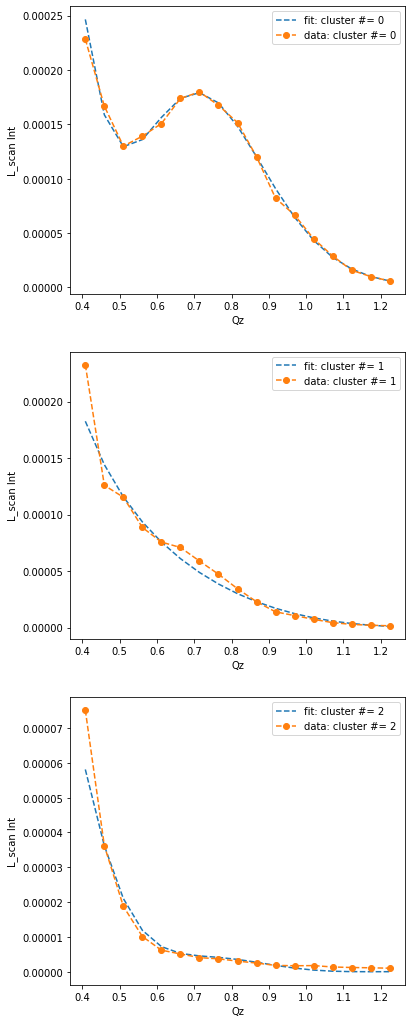

In [27]:
fig, axes = plt.subplots(len(lscan_centers),1, figsize=(6,18))
for ax, res, (cen, lscan) in zip(axes.flatten(), grad_result_list, enumerate(lscan_centers)):
    xrr_fit, e_dens = simFunc(res.x, lscan , qz_arr, crystal_layers, fit_return=True)
    ax.plot(qz_arr, xrr_fit , linestyle='dashed', label='fit: cluster #= %d' % cen)
    ax.plot(qz_arr, lscan, marker='o', linestyle='dashed', label='data: cluster #= %d' % cen)
    ax.set_xlabel('Qz')
    ax.set_ylabel('L_scan Int')
    ax.legend()
fig.savefig('fit_plots/fit_results_grad.png', dpi=200)